In [1]:
import json
import sys
import os
import numpy as np
import skimage
from scipy import ndimage
from scipy import special
from scipy import sparse
import anndata
import nibabel as nib
import pandas as pd
import datashader as ds
import time
from sklearn.decomposition import PCA
import collections
import pickle as pkl
import zarr
import h5py
import anndata # as ad

import numpy as np
import os
import matplotlib.pyplot as plt 
import pandas as pd
import nrrd
import logging
logging.basicConfig(level=logging.INFO)


import importlib
from dredFISH.Analysis.__init__plots import *
sns.set_style('white')
from dredFISH.Analysis import powerplots
importlib.reload(powerplots)
from dredFISH.Analysis import imageu
importlib.reload(imageu)
from dredFISH.Analysis import regu
importlib.reload(regu)
from dredFISH.Analysis import basicu
importlib.reload(basicu)

from dredFISH.Analysis import TissueGraph as tgh
importlib.reload(tgh)

<module 'dredFISH.Analysis.TissueGraph' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/TissueGraph.py'>

In [2]:
# sns.boxplot(scrna.values.flatten())
def group_sum(mat, groups, group_order=[]):
    """
    mat is a matrix (cell-by-feature) ; group are the labels (for each cell).
    
    this can be speed up!!! take advantage of the cluster label structure... check my metacell analysis script as well
    """
    m, n = mat.shape
    assert m == len(groups)
    if len(group_order) == 0:
        group_order = np.unique(groups)
    
    group_idx = basicu.get_index_from_array(group_order, groups)
    groupmat = sparse.csc_matrix(([1]*m, (group_idx, np.arange(m)))) # group by cell
    
    return groupmat.dot(mat), group_order

def group_mean(mat, groups, group_order=[]):
    """
    mat is a matrix (cell-by-feature) ; group are the labels (for each cell).
    """
    m, n = mat.shape
    assert m == len(groups)
    if len(group_order) == 0:
        group_order = np.unique(groups)
    
    group_idx = basicu.get_index_from_array(group_order, groups)
    groupmat = sparse.csc_matrix(([1]*m, (group_idx, np.arange(m)))) # group by cell
    groupmat = groupmat/np.sum(groupmat, axis=1)  # row
    
    return groupmat.dot(mat), group_order

def IQR_normalize_vector(v):
    v = v.copy()
    v = v-np.percentile(v,50)
    v = v/(np.percentile(v,75)-np.percentile(v,25))
    return v

def IQR_normalize_matrix_bycol(mat):
    mat = mat.copy()
    for i in range(mat.shape[1]):
        """ Scale bitwise first """
        mat[:,i] = IQR_normalize_vector(mat[:,i])
    return mat

def zscore(v, **kwargs):
    return (v-np.mean(v, **kwargs))/(np.std(v, **kwargs))

def zscore_matrix_bycol(mat):
    return zscore(mat, axis=0) # across rows

## Load data

In [3]:
### file paths
## inputs
# allen data
allen_template_path='/bigstore/binfo/mouse/Brain/average_template.npy'
allen_tree_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/structures.json'
allen_annot_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/annotation_10.nrrd'

# dredFISH data
dataset = 'DPNMF_PolyA_2021Nov19' # dataset tag
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
fish_path = f'{base_path}fishdata_2022Mar23/' # Zach's new version
# anndata_path = f'{base_path}results/raw_fishdata_Mar24.h5ad'
anndata_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v1_results_anndata.h5ad'

# ## output
# version = 'v1'
# outdir = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/'
# out_spatial_prefix = f"{outdir}{dataset}_{version}_spatialreg_"
# out_anndata = f"{outdir}{dataset}_{version}_results_anndata.h5ad"
# out_tmg = f"{outdir}{dataset}_{version}_results_tmg.pkl"

# # check output filenames
# logging.info(out_spatial_prefix)
# logging.info(out_anndata)
# logging.info(out_tmg)

In [4]:
%%time
# load Allen reference
# allen_template = regu.load_allen_template(allen_template_path)
allen_tree, allen_maps = regu.load_allen_tree(allen_tree_path)
# allen_annot = regu.load_allen_annot(allen_annot_path) # takes about 30 seconds

CPU times: user 28 ms, sys: 3.69 ms, total: 31.7 ms
Wall time: 128 ms


In [5]:
# allen scrna matrix
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
scrna = anndata.read_h5ad(f)
print(scrna.shape)
scrna

(73347, 24)


AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'cell_

In [6]:
%%time
# load dredFISH
TMG = tgh.TissueMultiGraph(name=dataset)
TMG.load_from_anndata(anndata_path)
    
# normalize (optional for spatial registration)
TMG.normalize_data(norm_cell=True, norm_bit=False)

### for now
data = TMG.data
data

INFO:root:113758 cells, minimum counts = 1248.0


CPU times: user 230 ms, sys: 176 ms, total: 406 ms
Wall time: 591 ms


AnnData object with n_obs × n_vars = 113758 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'cell_name', 'stage_x', 'stage_y', 'coord_x', 'coord_y', 'region_id', 'region_color', 'region_acronym'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors', 'norm_cell'

In [7]:
data

AnnData object with n_obs × n_vars = 113758 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'cell_name', 'stage_x', 'stage_y', 'coord_x', 'coord_y', 'region_id', 'region_color', 'region_acronym'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors', 'norm_cell'

In [8]:
data.layers['norm_cell']

array([[0.00304321, 0.02191114, 0.04808278, ..., 0.01095557, 0.02312842,
        0.13998783],
       [0.        , 0.00698324, 0.04329609, ..., 0.03631285, 0.01815642,
        0.14804469],
       [0.00743802, 0.02396694, 0.05123967, ..., 0.00743802, 0.02438017,
        0.14793389],
       ...,
       [0.00051282, 0.00923077, 0.03794872, ..., 0.00153846, 0.03589744,
        0.17076923],
       [0.        , 0.00764007, 0.02971138, ..., 0.        , 0.02801358,
        0.1663837 ],
       [0.        , 0.00599201, 0.04061252, ..., 0.00199734, 0.04860187,
        0.18708389]], dtype=float32)

In [9]:
'Isocortex' in allen_tree['acronym'].values, 'HPF' in allen_tree['acronym'].values

(True, True)

In [10]:
# select specific regions
selected_regions = ['Isocortex', 'HPF']
selected_all_sids = regu.expand_regions(allen_tree, selected_regions, 'acronym')

# selected cells
cond_cells = data.obs['region_id'].isin(selected_all_sids)
#               & (data.obs['total_signal'] > 0)
data_s = data[cond_cells]
data_s

View of AnnData object with n_obs × n_vars = 43767 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'cell_name', 'stage_x', 'stage_y', 'coord_x', 'coord_y', 'region_id', 'region_color', 'region_acronym'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors', 'norm_cell'

In [11]:
celltype_levels = [
    'class_label', 
    'neighborhood_label', 
    'subclass_label', 
    # 'supertype_label', 
    'cluster_label',
]
subclass_palette = scrna.obs.groupby('subclass_label').first()['subclass_color'].to_dict()

(scrna.obs['class_label'].unique().shape, 
 scrna.obs['neighborhood_label'].unique().shape, 
 scrna.obs['subclass_label'].unique().shape, 
 scrna.obs['cluster_label'].unique().shape
)

((3,), (8,), (42,), (382,))

# can we assign all cells into those 3 categories?

In [12]:
def plot_validation(Xp, xclsts, Yk, df, hue):
    """
    """
    mosaic="A"*10+"B"*10+"C"
    mosaic+=("\n"+"D"*21)*5 #+"\n"+"D"*21
    fig, axs = plt.subplot_mosaic(mosaic, figsize=(12, 6))
    ax = axs['A']
    sns.heatmap(Xp, 
                yticklabels=xclsts, xticklabels=True, 
                vmax=3, vmin=-3, cmap='coolwarm', 
                cbar_ax=axs['C'],
                # cbar_kws={'shrink':0.3, 'aspect':20, 'pad': 0.1},
                ax=ax)
    ax.set_title('scRNA-seq')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

    ax = axs['B']
    sns.heatmap(Yk, 
                yticklabels=[], xticklabels=True, 
                vmax=3, vmin=-3, cmap='coolwarm', 
                cbar=False,
                # cbar_kws={'shrink':0.3},
                ax=ax)
    ax.set_title('dredFISH')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    
    ax = axs['D']
    hue_order = np.sort(np.unique(df[hue]))
    sns.scatterplot(data=df, #[cond],
                    x='coord_x', y='coord_y', 
                    hue=hue,
                    hue_order=hue_order,
                    ax=ax,
                    s=3,
                    edgecolor='none',
                    color='gray',
                   )

    ax.legend(bbox_to_anchor=(0.5,0), loc='lower center')
    # ax.set_title('Predicted Allen cell types')
    ax.invert_yaxis()
    ax.axis('off')
    ax.set_aspect('equal')

    plt.show()
    
def plot_spatial_validation(df, hue):
    """
    """
    hue_order = np.sort(np.unique(df[hue]))

    fig, ax = plt.subplots(figsize=(10,6))
    sns.scatterplot(data=df, #[cond],
                    x='coord_x', y='coord_y', 
                    hue=hue,
                    hue_order=hue_order,
                    ax=ax,
                    s=3,
                    edgecolor='none',
                    color='gray',
                   )

    ax.legend(bbox_to_anchor=(0.5,0), loc='lower center')
    ax.set_title('Predicted Allen cell types')
    ax.invert_yaxis()
    ax.axis('off')
    ax.set_aspect('equal')
    plt.show()

In [13]:
# get X and Y (normalized by cells but not bits)
Xc = scrna.X
Xc = Xc/Xc.sum(axis=1).reshape(-1,1)

Yc = data_s.layers['norm_cell']
print(Xc.shape, Yc.shape)

(73347, 24) (43767, 24)


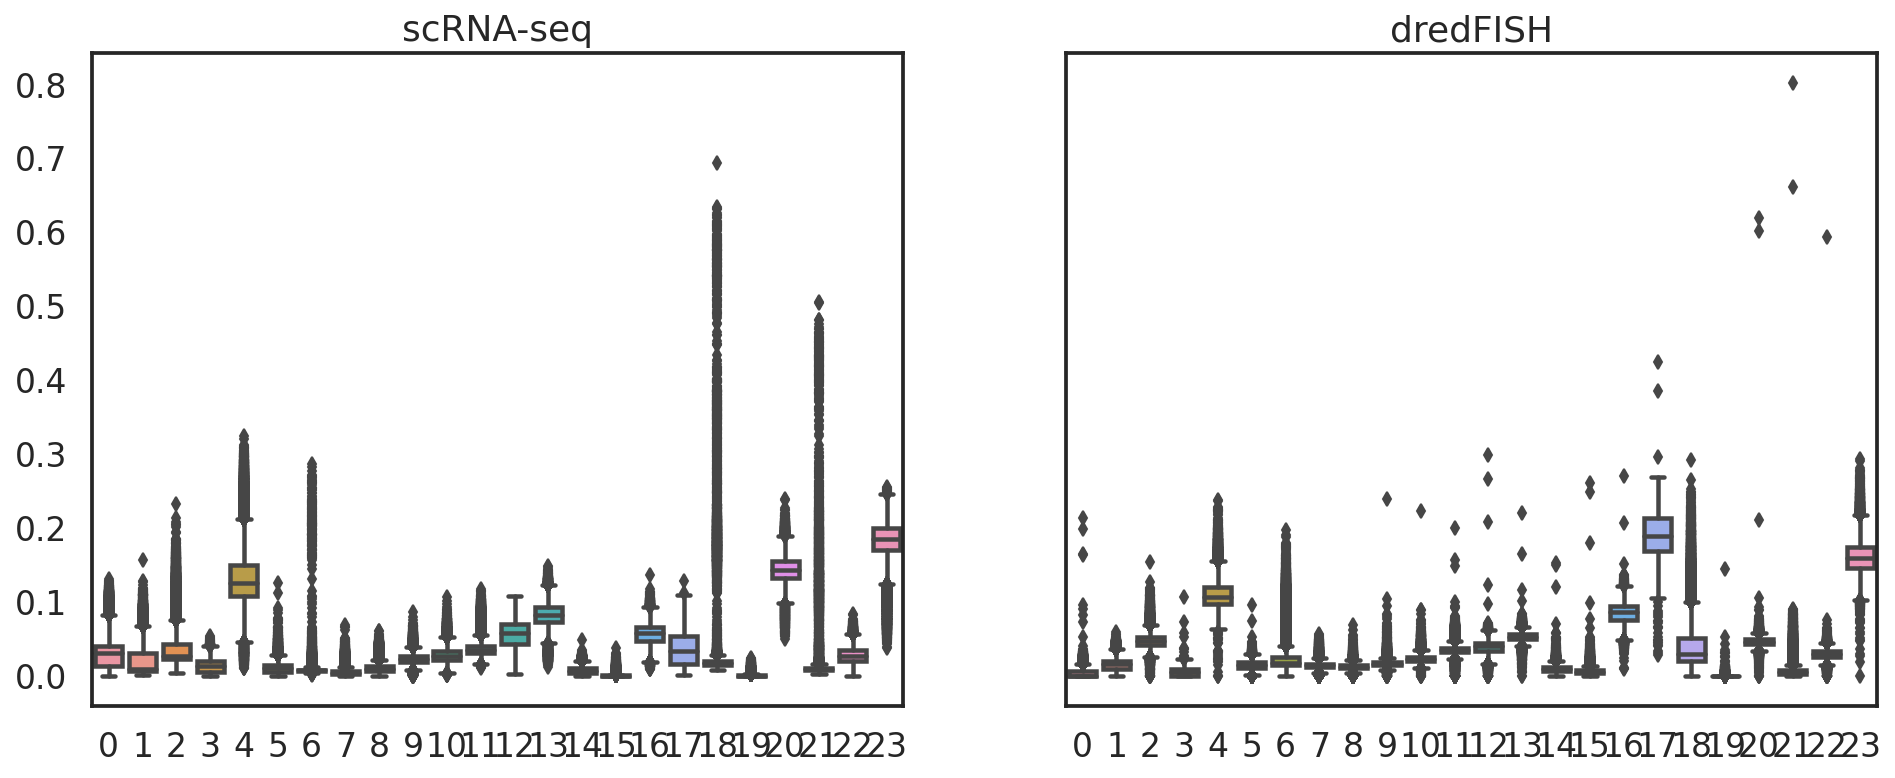

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(2*8,1*6), sharex=True, sharey=True)
ax = axs[0]
sns.boxplot(data=Xc, ax=ax)
ax.set_title('scRNA-seq')
ax = axs[1]
sns.boxplot(data=Yc, ax=ax)
ax.set_title('dredFISH')
plt.show()

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [16]:
# %%time

# # classification
# cluster_level = 'class_label'
# # cluster_level = 'subclass_label'

# xlabels = scrna.obs[cluster_level]
# classifier = KNeighborsClassifier(n_neighbors=10, metric='euclidean', algorithm='ball_tree')
# classifier.fit(Xc, xlabels)
# ypred = classifier.predict(Yc)
# print(np.unique(ypred, return_counts=True))

# # group mean
# # Yk, yclsts = group_mean(Yp, ypred)
# # Xk, xclsts = group_mean(Xcp, xlabels)
# Yk, yclsts = group_mean(Yc, ypred)
# Xk, xclsts = group_mean(Xc, xlabels)

# # results
# df = data_s.obs.copy()
# df['ypred'] = ypred

# # validation plot
# plot_validation(Xk, xclsts, Yk, df, 'ypred')

In [17]:
# %%time

# # classification
# cluster_level = 'class_label'
# # cluster_level = 'subclass_label'

# xlabels = scrna.obs[cluster_level]
# classifier = KNeighborsClassifier(n_neighbors=10, metric='correlation', algorithm='brute')
# classifier.fit(Xc, xlabels)
# ypred = classifier.predict(Yc)
# print(np.unique(ypred, return_counts=True))

# # group mean
# # Yk, yclsts = group_mean(Yp, ypred)
# # Xk, xclsts = group_mean(Xcp, xlabels)
# Yk, yclsts = group_mean(Yc, ypred)
# Xk, xclsts = group_mean(Xc, xlabels)

# # results
# df = data_s.obs.copy()
# df['ypred'] = ypred

# # validation plot
# plot_validation(Xk, xclsts, Yk, df, 'ypred')

(array(['GABAergic', 'Glutamatergic', 'Non-Neuronal'], dtype=object), array([ 8007, 29852,  5908]))


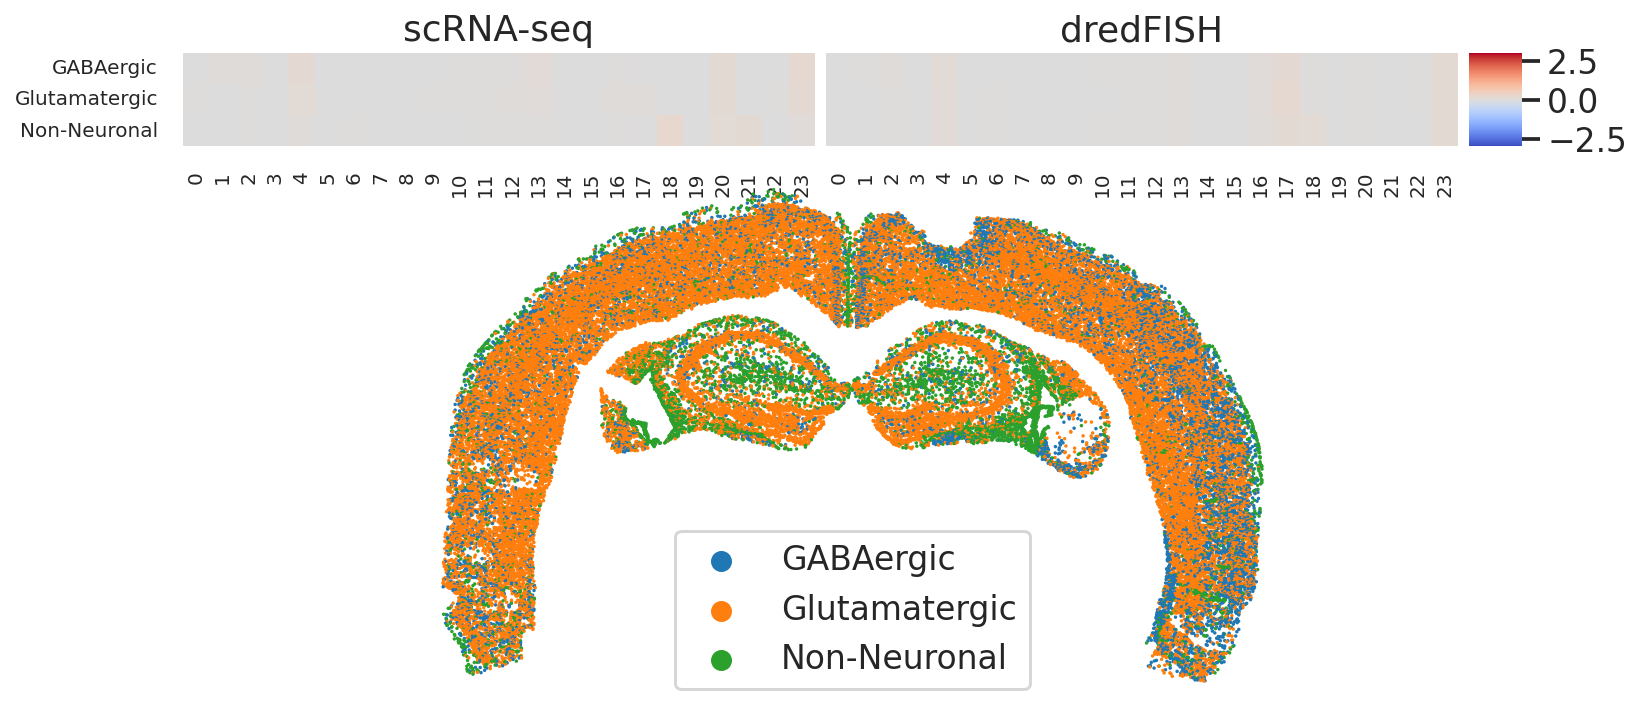

CPU times: user 2min 20s, sys: 118 ms, total: 2min 20s
Wall time: 2min 20s


In [18]:
%%time
# some rebalancing cell numbers
# classification
cluster_level = 'class_label'
# cluster_level = 'subclass_label'

xlabels = scrna.obs[cluster_level]
classifier = RandomForestClassifier(n_estimators=500)
classifier.fit(Xc, xlabels)
ypred = classifier.predict(Yc)
print(np.unique(ypred, return_counts=True))

# group mean
Yk, yclsts = group_mean(Yc, ypred)
Xk, xclsts = group_mean(Xc, xlabels)

# results
df = data_s.obs.copy()
df['ypred'] = ypred

# validation plot
plot_validation(Xk, xclsts, Yk, df, 'ypred')

In [19]:
# rebalancing

In [20]:
sbits = np.hstack([np.arange(19), np.arange(20, 24)])
sbits

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 20, 21, 22, 23])

In [21]:
%%time
# some rebalancing cell numbers
# classification
# cluster_level = 'class_label'
cluster_level = 'subclass_label'

xlabels = scrna.obs[cluster_level]
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(Xc[:,sbits], xlabels)
ypred = classifier.predict(Yc[:,sbits])
np.unique(ypred, return_counts=True)

CPU times: user 50.1 s, sys: 408 ms, total: 50.5 s
Wall time: 50.5 s


(array(['Astro', 'CA3', 'CR', 'Car3', 'L2/3 IT CTX', 'L2/3 IT PPP',
        'L4 RSP-ACA', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX',
        'L5/6 NP CTX', 'L6 CT CTX', 'L6 IT CTX', 'L6b CTX', 'Lamp5',
        'NP PPP', 'NP SUB', 'Oligo', 'Pvalb', 'SMC-Peri', 'Sncg', 'Sst',
        'Vip'], dtype=object),
 array([  833,     1,     1,     3,   571,  5346,   104, 31388,   646,
            3,  1772,   190,    17,     9,  1473,    54,    36,    40,
          317,     2,     3,     4,   954]))

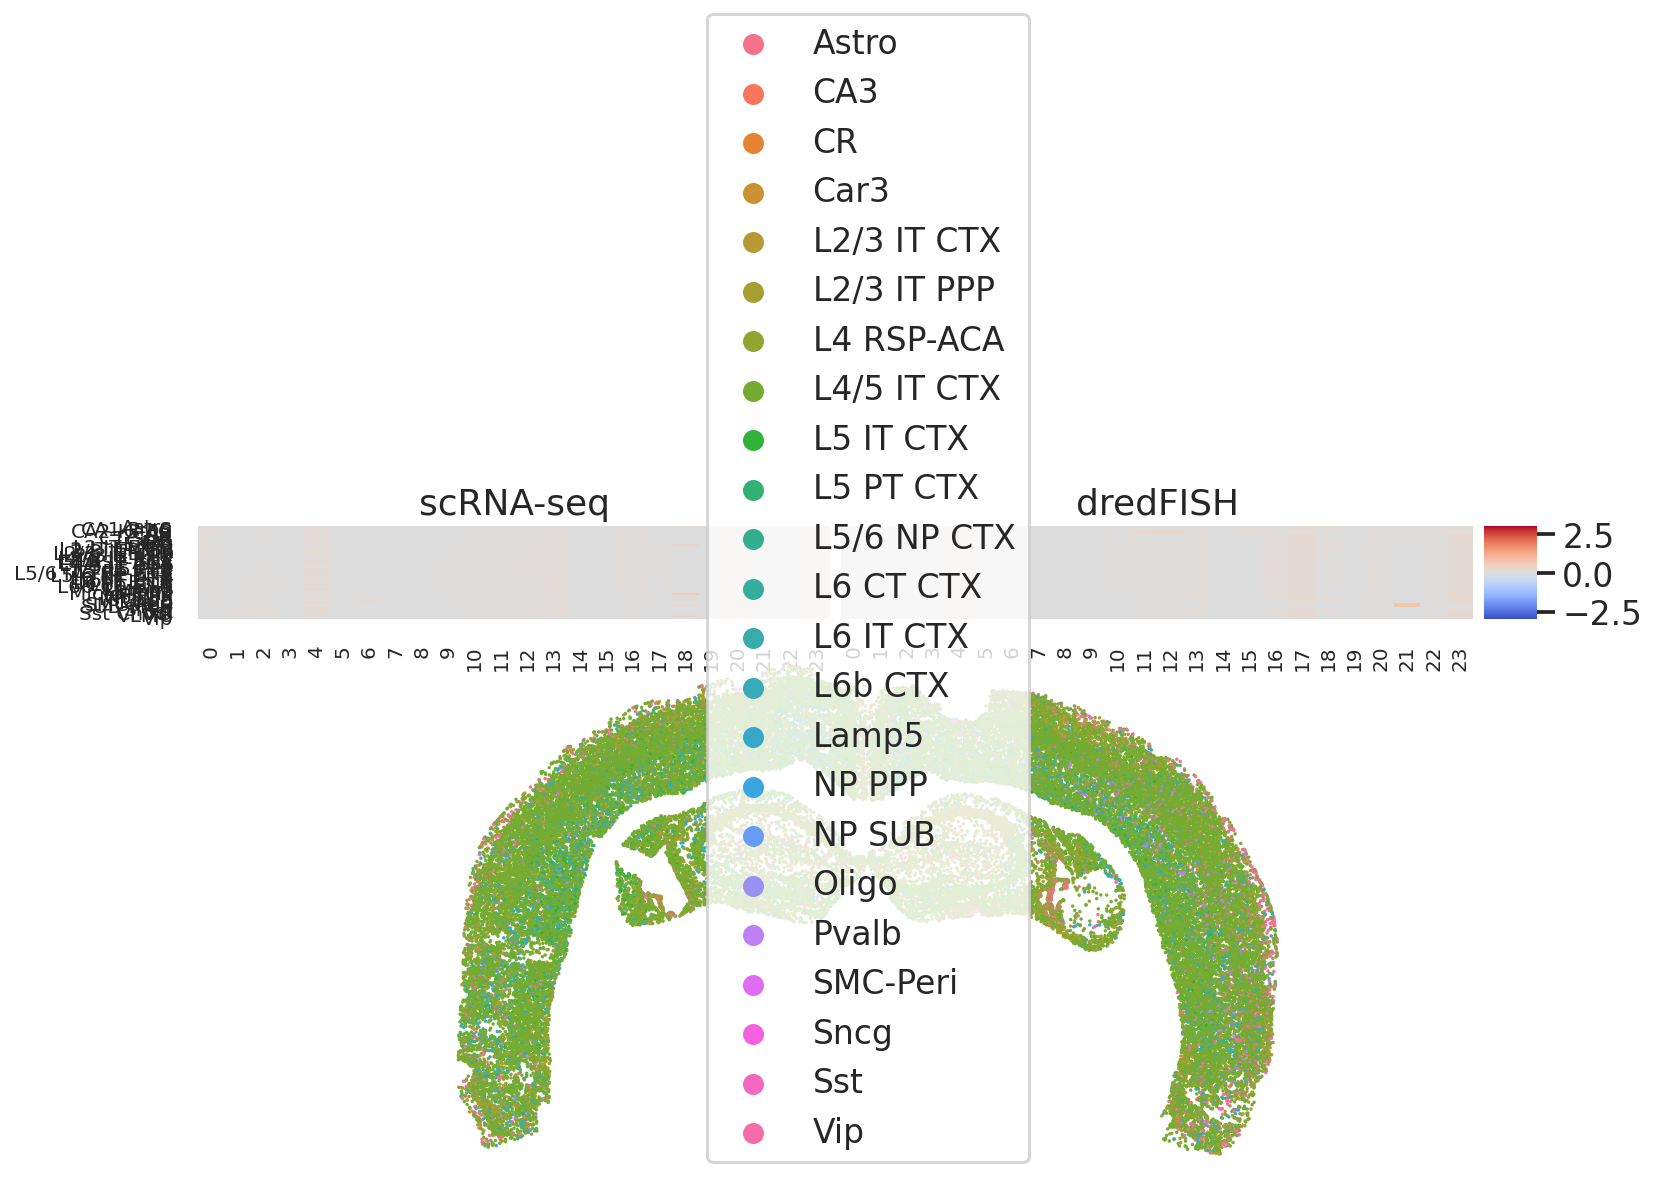

In [22]:
# group mean
Yk, yclsts = group_mean(Yc, ypred)
Xk, xclsts = group_mean(Xc, xlabels)

# results
df = data_s.obs.copy()
df['ypred'] = ypred

# validation plot
plot_validation(Xk, xclsts, Yk, df, 'ypred')

In [23]:
# check if layered structures exist
# allen_tree.set_index('sid').loc[regu.expand_regions(allen_tree, ['SSp'], by='acronym')]['acronym'].tolist()

In [24]:
subclass_manual_order = np.array([
 'Lamp5',
 'Sncg',
 'Vip',
 'Pvalb',
 'Sst',
 'Sst Chodl',
 'Meis2',
    
 'L2/3 IT CTX',
 'L4/5 IT CTX',
 'L5 IT CTX',
 'L6 IT CTX',
    
 'L2 IT ENTm',
 'L2 IT ENTl',
 'L2/3 IT ENTl',
 'L3 IT ENT',
 'L5/6 IT TPE-ENT',
 'L6 IT ENTl',
    
 'L2/3 IT PPP',
 'L2/3 IT RHP',
    
 'Car3',
    
 'L6 CT CTX',
 'CT SUB',
 'L6b CTX',
 'L6b/CT ENT',
 'L5/6 NP CTX',
 'NP PPP',
 'NP SUB',
    
 'L4 RSP-ACA',
 'L5 PPP',
 'L5 PT CTX',
    
 'SUB-ProS',
 'CA1-ProS',
 'CA2-IG-FC',
 'CA3',
 'DG',
    
 'CR',
    
 'Astro',
 'Endo',
 'Micro-PVM',
 'Oligo',
 'SMC-Peri',
 'VLMC',
])

col_manual_order = np.array([
    1, 2, # inhibitory
    4, # Pvalb
    
    5, 17, 
    12, 22, 
    23, 
    14, 20,
    0, 
    
    16, 
    
    
    10, 13, 9,
    
    7, # Pan L6: NP, CT, L6b, Sub
    3, # L6b/CT
    15, # NP
    8, # PT
    19, 11, # pan hippo 
    6, 21, 18, # non-neuronal
])
splitat = pd.Series(np.arange(len(subclass_manual_order)), index=subclass_manual_order).loc[[
    'Meis2', 
    'L6 IT CTX',
    'L6 IT ENTl',
    'Car3',
    'NP SUB',
    'L5 PT CTX',
    'DG',
    'CR',
]]

splitat_v = pd.Series(np.arange(len(col_manual_order)), index=col_manual_order).loc[[
    4, 9,
]]

In [25]:
def stratified_sample(df, col, n, **kwargs):
    """
    n represents number per group
    """
    dfsub = df.groupby(col, **kwargs).apply(lambda x: x.sample(n=min(len(x), n), random_state=0))
    return dfsub

In [26]:
%%time

# classification
# cluster_level = 'class_label'
cluster_level = 'subclass_label'

xlabels = scrna.obs[cluster_level]
classifier = KNeighborsClassifier(n_neighbors=10, metric='euclidean', algorithm='ball_tree')
classifier.fit(Xcp, xlabels)
ypred = classifier.predict(Yp)
np.unique(ypred, return_counts=True)

NameError: name 'Xcp' is not defined

In [27]:
# group mean
Xk, xclsts = group_mean(Xcp, xlabels)
Yk, yclsts = group_mean(Yp, ypred)

# results
df = data_selected.obs.copy()
df['ypred'] = ypred
df['index'] = np.arange(len(df))

# rearange order
rows = basicu.get_index_from_array(xclsts, subclass_manual_order)
cols = col_manual_order
Xvis = pd.DataFrame(Xk[rows], index=xclsts[rows])[cols]

## consider missing clusters 
rows = basicu.get_index_from_array(yclsts, subclass_manual_order)
cols = col_manual_order
Yvis = pd.DataFrame(
    np.vstack([Yk, np.zeros(24)])[rows],
    index=np.hstack([yclsts, '**NA**'])[rows],
    )[cols]

# individual cells
n = 50
dfsub = stratified_sample(df, 'ypred', n) #['ypred']
rows = [clst for clst in subclass_manual_order if clst in yclsts]
cols = col_manual_order

dfsub = dfsub.reindex(rows, level=0)
clst_sizes = dfsub['ypred'].value_counts().reindex(rows)
Yviz_cell = Yp[dfsub['index'].values][:,cols]

NameError: name 'Xcp' is not defined

In [ ]:
def plot_validation_genes_level3(Xmat, Ymat, splitat, splitat_v):
    """
    """
    mosaic="A"*10+"B"*10 #+"C"
    # mosaic+=("\n"+"D"*21)*5 #+"\n"+"D"*21

    fig, axs = plt.subplot_mosaic(mosaic, figsize=(12, 10))
    cbar_ax = fig.add_axes([.96, .4, .01, .2])
    ax = axs['A']
    sns.heatmap(Xmat, 
                yticklabels=True, xticklabels=True, 
                vmax=3, vmin=-3, cmap='coolwarm', 
                cbar_ax=cbar_ax,
                cbar_kws=dict(label='normed features'),
                ax=ax)
    ax.set_title('scRNA-seq')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0)
    # lines
    ax.hlines(1+splitat.values, 0, Ymat.shape[1], linewidth=0.5, color='gray')
    ax.vlines(1+splitat_v.values, 0, Ymat.shape[0], linewidth=0.5, color='gray')

    ax = axs['B']
    ax.yaxis.tick_right()
    sns.heatmap(Ymat, 
                # yticklabels=True, #[yl if yl == '**NA**' else "" for yl in Ymat.index], 
                xticklabels=True, 
                vmax=3, vmin=-3, cmap='coolwarm', 
                cbar=False,
                ax=ax)
    ax.set_title('dredFISH')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    # ylabels
    ylabels = Ymat.index.values
    ax.set_yticks(0.5+np.arange(len(ylabels))[ylabels=='**NA**'])
    ax.set_yticklabels(ylabels[ylabels=='**NA**'], fontsize=10, rotation=0)
    # lines
    ax.hlines(1+splitat.values, 0, Ymat.shape[1], linewidth=0.5, color='gray')
    ax.vlines(1+splitat_v.values, 0, Ymat.shape[0], linewidth=0.5, color='gray')
    
    fig.subplots_adjust(wspace=0.3)
    plt.show()
    
def plot_validation_genes_level3_expand(Yviz_cell, clst_sizes, splitat_v, n):
    """
    """
    Ymat = Yviz_cell
    fig, ax = plt.subplots(figsize=(8,15))
    sns.heatmap(Ymat, 
                yticklabels=[], xticklabels=True, 
                vmax=3, vmin=-3, cmap='coolwarm', 
                # cbar_ax=cbar_ax,
                cbar_kws=dict(label='normed features', shrink=0.2),
                ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    
    for (clst, y) in np.cumsum(clst_sizes).iteritems():
        ax.text(0, y, clst, ha='right', fontsize=10)
        ax.axhline(y, color='white', linewidth=1)
    ax.vlines(1+splitat_v.values, 0, Ymat.shape[0], linewidth=0.5, color='white')
    ax.set_title(f"dredFISH cells\n(n={n} cells per cell type)")
    
    plt.show()
    


In [ ]:
def plot_validation_spatial_level3(df, hue, hue_order, palette):
    """
    """
    # hue_order = np.sort(np.unique(df[hue]))

    fig, ax = plt.subplots(figsize=(10,6))
    sns.scatterplot(data=df, #[cond],
                    x='coord_x', y='coord_y', 
                    hue=hue,
                    hue_order=hue_order,
                    palette=palette,
                    ax=ax,
                    s=3,
                    edgecolor='none',
                    # color='gray',
                   )

    ax.legend(bbox_to_anchor=(0.5,0), loc='upper center', fontsize=10, ncol=5)
    ax.set_title('Predicted Allen cell types')
    ax.invert_yaxis()
    ax.axis('off')
    ax.set_aspect('equal')
    plt.show()
    
# individual clusters (using Allen color)
def plot_validation_spatial_level3_expand(df, hue, hue_order, palette):
    """
    """
    nx = 6
    ny = 7
    # hue_order = np.sort(np.unique(df[hue]))
    # clusters = np.sort(np.unique(df[hue]))

    fig, axs = plt.subplots(ny, nx, figsize=(4*nx,2.5*ny))
    fig.subplots_adjust(wspace=0, hspace=0)
    for i, (cluster, ax) in enumerate(zip(hue_order, axs.flat)):
        cond = (df[hue] == cluster)
        sns.scatterplot(data=df, 
                        x='coord_x', y='coord_y', 
                        ax=ax,
                        s=.5,
                        edgecolor='none',
                        color='lightgray',
                        rasterized=True,
                       )
        sns.scatterplot(data=df[cond], #[cond],
                        x='coord_x', y='coord_y', 
                        # hue=hue,
                        # hue_order=hue_order,
                        ax=ax,
                        s=5,
                        edgecolor='none',
                        color=palette[cluster],
                        rasterized=True,
                       )
        ax.set_title(cluster, loc='center', y=0, fontsize=15)
        ax.invert_yaxis()
        ax.axis('off')
        ax.set_aspect('equal')

    for ax in axs.flat[i:]:
        ax.axis('off')
    plt.show()

In [ ]:
subclass_palette_new = {clst: color 
                        for clst, color in 
                        zip(subclass_manual_order, np.array(sns.color_palette("husl", len(subclass_manual_order))))
                        }
# subclass_palette_new

In [ ]:
# validation plot
plot_validation_genes_level3(Xvis, Yvis, splitat, splitat_v)
plot_validation_spatial_level3(df, 'ypred', subclass_manual_order, subclass_palette_new)

In [ ]:
plot_validation_spatial_level3_expand(df, 'ypred', subclass_manual_order, subclass_palette_new)

In [ ]:
plot_validation_genes_level3_expand(Yviz_cell, clst_sizes, splitat_v, n)